# Automatic style transfer

The aim of this pipeline is to, given an image, find an image that have a similar content but a different style, and then apply a photorealistic style transfer.

Several requirements are needed to run it:
 - run `python install.py`
 - a gpu (for the segmentation part)

## Image segmentation

### Model

Image segmentation we will use is from the semantic-segmentation-pytorch project available here: https://github.com/CSAILVision/semantic-segmentation-pytorch.git (it is automatically downloaded by `install.py`)

# Proof of concept : nighty landscapes

## Imports and preparation

In [1]:
from toolbox.path_setup import *
from toolbox.segmentation import *
import numpy as np
import matplotlib.pyplot as plt
import toolbox.compute_content_losses as ccl
import seaborn as sns

In [2]:
name_experiment = "landscape"
_, images_path, _, _ = prepare_experiment(name_experiment)

## Landscape images

With this project, several landscape images (day and night) are available. They are stored in `examples/landscape/images`.

In [3]:
def plot_small(d,images):
    fig=plt.figure(figsize=(16, 8))
    columns = 6
    rows = len(images)//columns
    for i in range(0, len(images)):
        img = mpimg.imread(d + "/" + images[i])
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(img)
    plt.show()

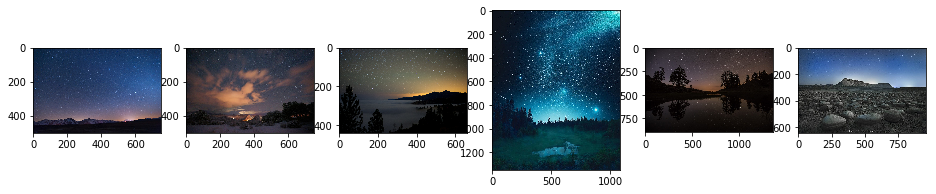

In [4]:
nightlandscapes = ["landscapenight{}.jpg".format(i) for i in range(4,10)]
plot_small(images_path,nightlandscapes)

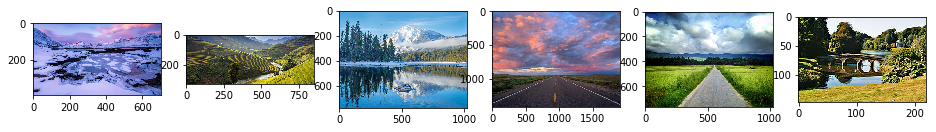

In [ ]:
landscapes = ['landscape{}.jpg'.format(i) for i in range(10,16)]
plot_small(images_path,landscapes)

## Segmentation

Now, let's try to give the lake image a "nighty" look! To do some we need two things:
 - semantically segment the image to find the different regions inside it;
 - find the best style image (among night landscapes).

In [ ]:
base_image = landscapes[2]
images = [base_image]
cli, masks, results = generate_segmentation_cli(name_experiment,images)
! cd semsegpt; python $cli
for image in images:
    res_path = results + "/" + image[:-4] + '.png'
    save_segmentation(res_path, masks)

Input arguments:
test_imgs        ['../examples/landscape/images/landscape12.jpg']
model_path       models/baseline-resnet50dilated-ppm_deepsup
suffix           _epoch_20.pth
arch_encoder     resnet50dilated
arch_decoder     ppm_deepsup
fc_dim           2048
num_val          -1
num_class        150
batch_size       1
imgSize          [300, 400, 500, 600]
imgMaxSize       1000
padding_constant 8
segm_downsampling_rate 8
result           ../examples/landscape/images
gpu              0
Loading weights for net_encoder
Loading weights for net_decoder
# samples: 1
100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.17s/it]
Inference done!
examples/landscape/images/landscape12.png examples/landscape/images


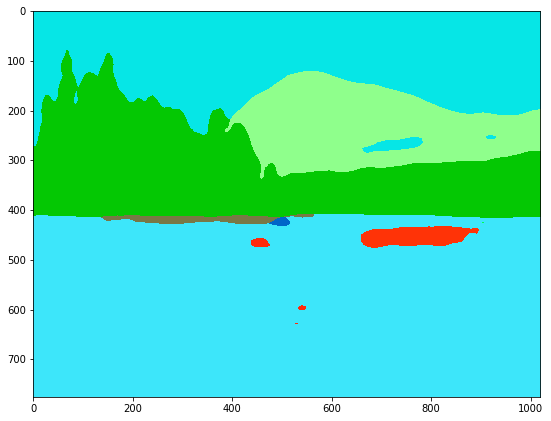

In [ ]:
plot_segmented_images(results,images)

Now we do the same for the night landscapes: we will then be able to compare what is inside the images!

In [ ]:
cli, masks, results = generate_segmentation_cli(name_experiment,nightlandscapes)
! cd semsegpt; python $cli
for image in nightlandscapes:
    res_path = results + "/" + image[:-4] + '.png'
    save_segmentation(res_path, masks)

Input arguments:
test_imgs        ['../examples/landscape/images/landscapenight4.jpg', '../examples/landscape/images/landscapenight5.jpg', '../examples/landscape/images/landscapenight6.jpg', '../examples/landscape/images/landscapenight7.jpg', '../examples/landscape/images/landscapenight8.jpg', '../examples/landscape/images/landscapenight9.jpg']
model_path       models/baseline-resnet50dilated-ppm_deepsup
suffix           _epoch_20.pth
arch_encoder     resnet50dilated
arch_decoder     ppm_deepsup
fc_dim           2048
num_val          -1
num_class        150
batch_size       1
imgSize          [300, 400, 500, 600]
imgMaxSize       1000
padding_constant 8
segm_downsampling_rate 8
result           ../examples/landscape/images
gpu              0
Loading weights for net_encoder
Loading weights for net_decoder
# samples: 6
100%|█████████████████████████████████████████████| 6/6 [00:38<00:00,  6.41s/it]Inference done!

examples/landscape/images/landscapenight4.png examples/landscape/images
ex

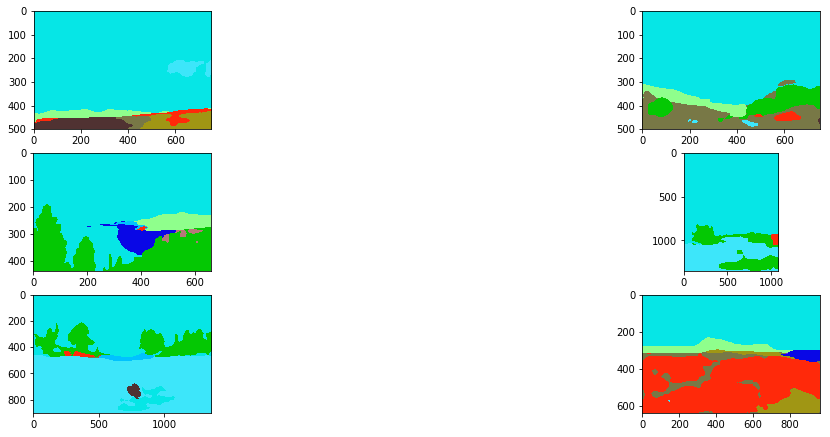

In [ ]:
plot_segmented_images(results,nightlandscapes)

As we can see, the segmentation network is not perfoming as well on night images than on day images...

## Choosing best mate

Among the 6 style images, we will choose the one that minimizes the loss content. That's the goal of ccl.Calculator.

In [ ]:
calc = ccl.Calculator(device="cuda")
calc.setup_reference(images_path+"/"+base_image)
image_distances = []
for image in nightlandscapes:
    image_distances.append(calc.run(images_path+"/"+image).data.cpu().numpy())
print(image_distances)

[array(831.99756, dtype=float32), array(730.2441, dtype=float32), array(732.3783, dtype=float32), array(672.94635, dtype=float32), array(644.885, dtype=float32), array(766.4845, dtype=float32)]


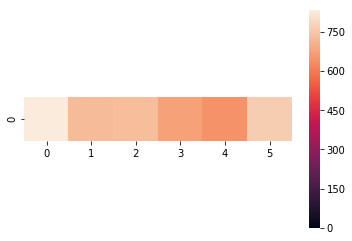

In [ ]:
sns.heatmap([image_distances],vmin=0,square=True)

The darker a square is, the closer the images are in term of content. In this case it is image number 5:

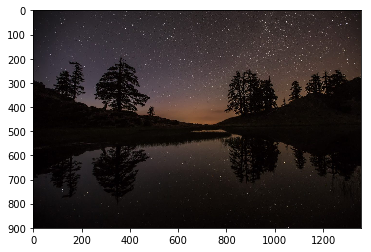

In [ ]:
img = mpimg.imread(images_path + "/" + nightlandscapes[4])
plt.imshow(img)

The image is pretty close of our base one : the two images are both lake images.

## Time to do some style transfer !

In [ ]:
# transform jpg images into png
from PIL import Image
img = Image.open("examples/landscape/images/"+base_image)
img.save("examples/landscape/images/"+base_image[:-4] + ".png", "PNG")
img = Image.open("examples/landscape/images/"+nightlandscapes[4])
img.save("examples/landscape/images/"+nightlandscapes[4][:-4] + ".png", "PNG")

In [ ]:
import torch
import torchvision.models as models
import os


name = "5"
num_epochs = 500

quick = False
ghost  = False
quiet = False

content_image = "landscape/images/" + base_image[:-4]
style_image = "landscape/images/" + nightlandscapes[4][:-4]
device = 'cuda' if torch.cuda.is_available() else 'cpu'
imsize = 128 if torch.cuda.is_available() else 128

style_weight = 1e6
content_weight = 1e2
reg_weight = 1e-11

content_layers = ['4_2']
style_layers = ['1_1','2_1','3_1','4_1']

optimizer = "lbfgs"
learning_rate = 1
momentum = 0.9
weight_decay = 1e-3

scheduler = "step"
lr_step = 10000
lr_decay = 5e-1

query = "main.py -name {} -device {} -num_epochs {} -style_image {} -content_image {} -imsize {} -style_weight {} -content_weight {} -reg_weight {} -content_layers {} -style_layers {} -optimizer {} -lr {} -momentum {} -weight_decay {} -scheduler {} -lr_step {} -lr_decay {}".format(
    name,
    device,
    num_epochs,
    content_image,
    style_image,
    imsize,
    style_weight,
    content_weight,
    reg_weight,
    " ".join(content_layers),
    " ".join(style_layers),
    optimizer,
    learning_rate,
    momentum,
    weight_decay,
    scheduler,
    lr_step,
    lr_decay
  )

if quick:
    query += " -quick"
if ghost:
    query += " -ghost"
if quiet:
    query += " -quiet"

In [ ]:
from main import *

%matplotlib inline

experience = create_experience(query)

parameters = experience["parameters"]
experiment = experience["experiment"]
listener = experience["listener"]
log = experience["log"]
optimizer = experience["optimizer"]
losses = experience["losses"]
model = experience["model"] 
scheduler = experience["scheduler"]

run_experience(experiment, model, parameters, losses, optimizer, scheduler, listener, log)

print()

experiment.input_image.data.clamp_(0, 1)

log.info("Done style transfering over "+str(experiment.epoch)+" epochs!")

if parameters.save_model:
    save_all(experiment,model,parameters,listener)
if not(parameters.ghost):
    save_images(parameters.res_dir+"output.png",experiment.style_image,experiment.input_image,experiment.content_image)

print("All done")

In [ ]:
plt_images(experiment.style_image,experiment.input_image,experiment.content_image)

In [ ]:
if not(parameters.no_metrics):
    generate_plots(parameters, listener)